#Importing necessary Libraries

In [41]:
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt

# Defining the time range

In [42]:
start = dt.datetime(1992, 1, 1)
end = dt.datetime(2022, 6, 1)

# Fetching the unadjusted monthly sales data

In [43]:
series = pdr.DataReader('RSXFS', 'fred', start, end)
series = series.rename(columns={'RSXFS': 'Sales'})

# Add Year and Month columns

In [44]:
series.index = pd.to_datetime(series.index)
series['Year'] = series.index.year
series['Month'] = series.index.month

# Simple Average Method

The Simple Average values represent how each month's sales compare to the average monthly sales over the years.
For example, June (101.68) means June sales are 1.68% higher than the average month, while January (99.19) is 0.81% lower than the average.
This method gives a quick understanding of seasonal peaks and dips.

In [45]:
simple_avg = series.groupby('Month')['Sales'].mean()
index_simple = (simple_avg / simple_avg.mean()) * 100


#Ratio-to-Moving-Average Method

This method smooths the data using moving averages and computes the ratio of actual values to smoothed values.
A value like March (100.19) means actual sales were very close to the moving average (i.e., on trend), while April (99.75) shows a slight dip below the moving average.
This method helps highlight true seasonal effects after removing short-term fluctuations.

In [46]:
series['12_MA'] = series['Sales'].rolling(window=12, center=True).mean()
series['Ratio_MA'] = (series['Sales'] / series['12_MA']) * 100
index_ma = series.dropna().groupby('Month')['Ratio_MA'].mean()


#Ratio-to-Trend Method

Here, the actual monthly values are compared to a trend line fitted to the data (often linear or exponential).
A value such as May (100.56) indicates sales were 0.56% above the trend, while December (99.95) was slightly below the trend.
# This approach reveals how seasonal variations deviate from the long-term trend.

In [47]:
import numpy as np
from sklearn.linear_model import LinearRegression

series['t'] = np.arange(len(series))
series = series.dropna(subset=['Sales'])
model = LinearRegression().fit(series[['t']], series['Sales'])
series['Trend'] = model.predict(series[['t']])
series['Ratio_Trend'] = (series['Sales'] / series['Trend']) * 100
index_trend = series.groupby('Month')['Ratio_Trend'].mean()


#Link Relative Method

This method calculates the month-over-month relative change and adjusts them to average 100.
For instance, February (100.28) means sales increased slightly from January to February.
It's useful for understanding how months relate sequentially, helping in short-term forecasting.

In [48]:
series['Link_Relative'] = series['Sales'].pct_change() * 100 + 100
index_link = series.dropna().groupby('Month')['Link_Relative'].mean()


# Compiling Seasonal Indices

In [49]:
seasonal_df = pd.DataFrame({
    'Simple Avg': index_simple,
    'Ratio to MA': index_ma,
    'Ratio to Trend': index_trend,
    'Link Relative': index_link
}).round(2)

print(seasonal_df)


       Simple Avg  Ratio to MA  Ratio to Trend  Link Relative
Month                                                        
1           99.19       100.07          100.24         100.49
2           99.42        99.96          100.16         100.28
3          100.19       100.19          100.47         100.63
4          100.01        99.75          100.14          99.91
5          100.96       100.20          100.56         100.93
6          101.68       100.46          100.87         100.65
7           99.01       100.40          100.14         100.33
8           99.34       100.35          100.11         100.33
9           99.56       100.19          100.01         100.24
10         100.02       100.32          100.19         100.53
11         100.22       100.11          100.04         100.19
12         100.41        99.97           99.95         100.25


#Visualizing the Indices

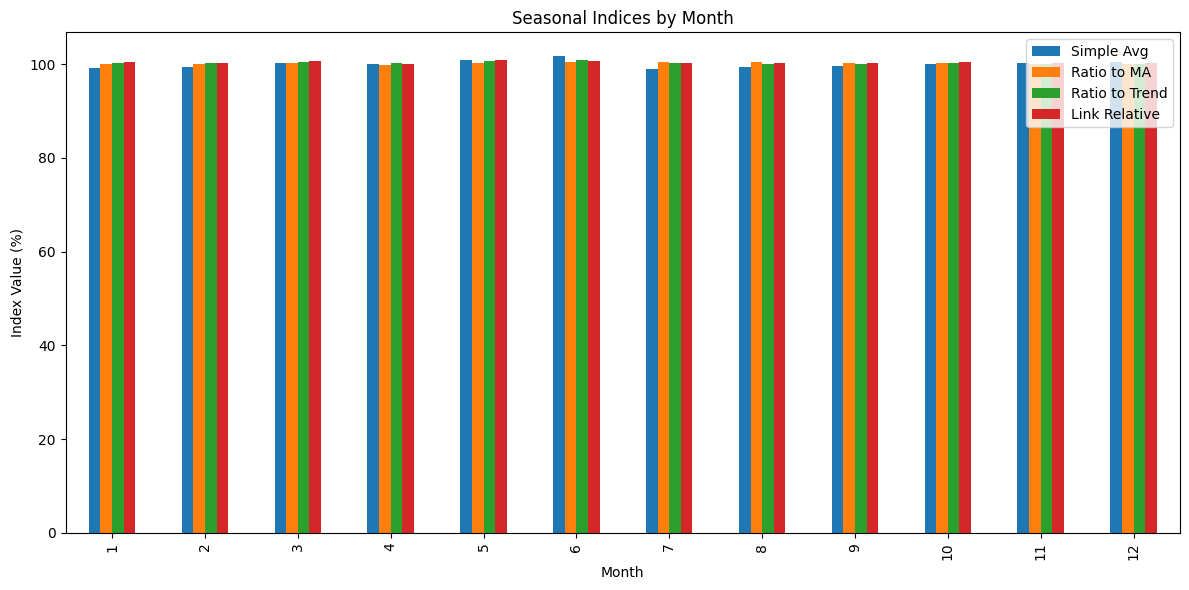

In [50]:
import matplotlib.pyplot as plt

seasonal_df.plot(kind='bar', figsize=(12, 6))
plt.title('Seasonal Indices by Month')
plt.xlabel('Month')
plt.ylabel('Index Value (%)')
plt.legend()
plt.tight_layout()
plt.show()
